In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import scipy
import codecs

%matplotlib inline  
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (15, 8)

from sklearn import linear_model
import numpy.ma as ma

## Input some data and run correlations

In [61]:
columns_to_drop = []

In [209]:
data = pd.read_csv('dataset_16', sep='\t', header=None)

In [210]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,10,43,5825543,69,60,0,1407606829,0,-24,вс,0,1414776005,-,424668,-,3
1,2,1,334,129,31,112227,2,1,1415699671,0,-29,пн,0,1386786500,86401,1274004,1415714518,21
2,2,1,1,5,5825543,315,25219,1,1415428541,0,-26,пн,0,1415612168,-,49380,-,16
3,1,1,422,2,5825543,392,44,1,1411245251,0,22,вс,0,1379156172,-,19752,-,20
4,1,1,0,580,7699829,500,161068,1,1354122839,0,26,вс,0,1415715882,3,5728080,1415715885,18


In [211]:
val_to_num = {'пн':1, 'вт':2, 'ср':3, 'чт':4, 'пт':5, 'сб':6, 'вс':7, '-':0, '':0}

ncols = 18
for i in range(ncols):
    data[i] = [val_to_num[s] if s in val_to_num.keys() else float(s) for s in data[i]]

In [212]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,1.0,10.0,43.0,5825543.0,69.0,60.0,0.0,1.407607e+09,0.0,-24.0,7,0.0,1.414776e+09,0.0,424668.0,0.000000e+00,3.0
1,2.0,1.0,334.0,129.0,31.0,112227.0,2.0,1.0,1.415700e+09,0.0,-29.0,1,0.0,1.386786e+09,86401.0,1274004.0,1.415715e+09,21.0
2,2.0,1.0,1.0,5.0,5825543.0,315.0,25219.0,1.0,1.415429e+09,0.0,-26.0,1,0.0,1.415612e+09,0.0,49380.0,0.000000e+00,16.0
3,1.0,1.0,422.0,2.0,5825543.0,392.0,44.0,1.0,1.411245e+09,0.0,22.0,7,0.0,1.379156e+09,0.0,19752.0,0.000000e+00,20.0
4,1.0,1.0,0.0,580.0,7699829.0,500.0,161068.0,1.0,1.354123e+09,0.0,26.0,7,0.0,1.415716e+09,3.0,5728080.0,1.415716e+09,18.0


In [213]:
data = np.array(data)

/usr/local/Cellar/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/Cellar/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


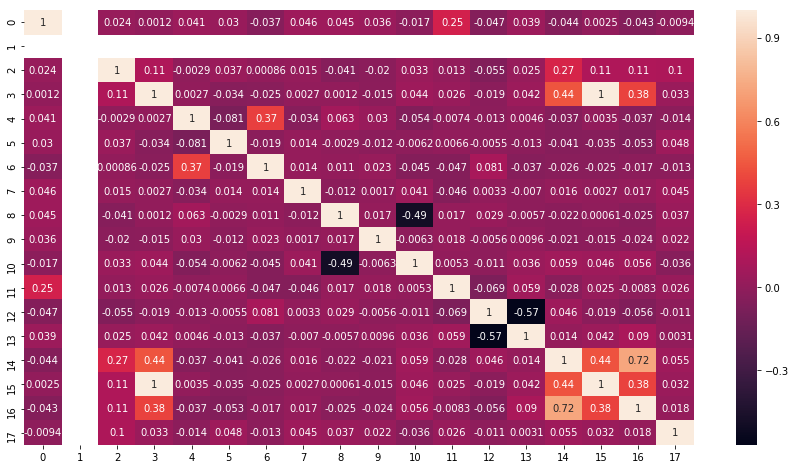

In [214]:
dataT = data.T

ax = plt.axes()
seaborn.heatmap(np.corrcoef(dataT), annot=True, ax=ax)

In [215]:
#  dataT[1] is const==1, it has no correlation with other values
pd.Series(dataT[1]).describe()

count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [62]:
columns_to_drop.append(1)

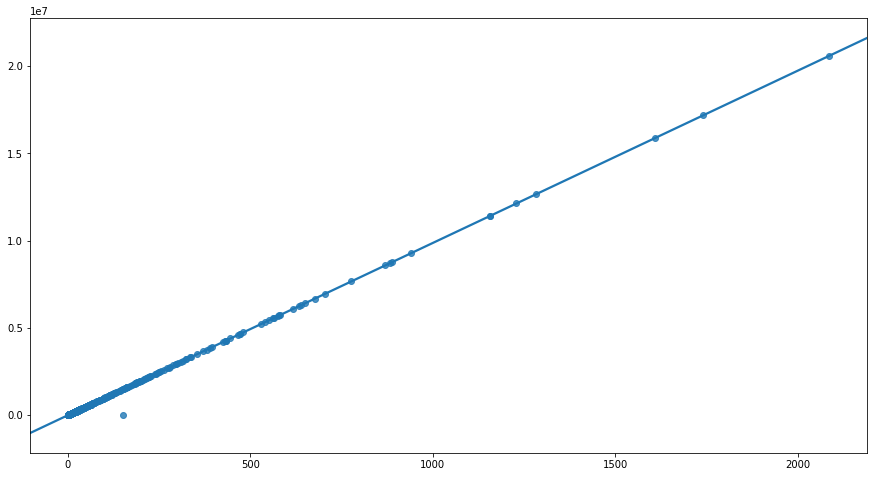

In [64]:
seaborn.regplot(dataT[3], dataT[15])

Видим, что столбцы 3 и 15 идентичны по модулю масштаба и одного из значений, которое в третьем столбце принимает что-то около 150, а в 15-ом столбце равно нулю. Скорее всего, это просто пропущенное значение и раз уж нам либо третий, либо пятнадцатый столбец удалять, давайте удалим 15-й, так как в нем не достает одного значения:

In [65]:
columns_to_drop.append(15)

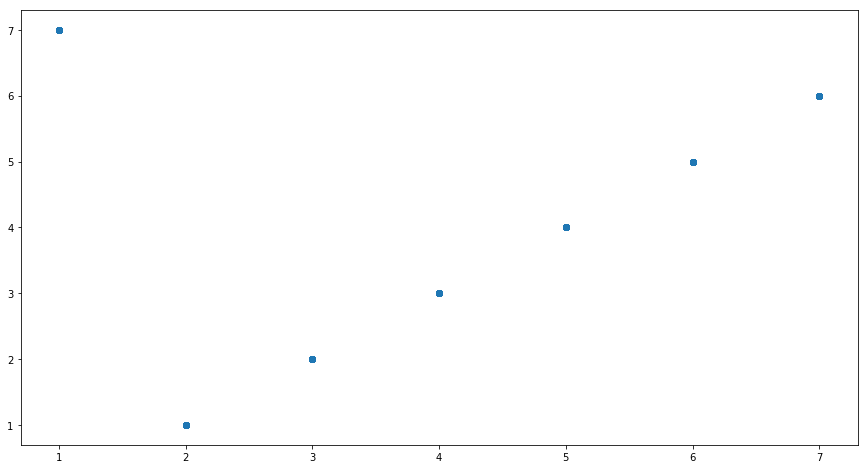

In [68]:
seaborn.regplot(dataT[0], dataT[11], fit_reg=False)

Видим, что все точки собрались в кучки, что значит, что в нулевом столбце числа описывают дни недели, но начиная с воскресенья.

In [69]:
columns_to_drop.append(0)

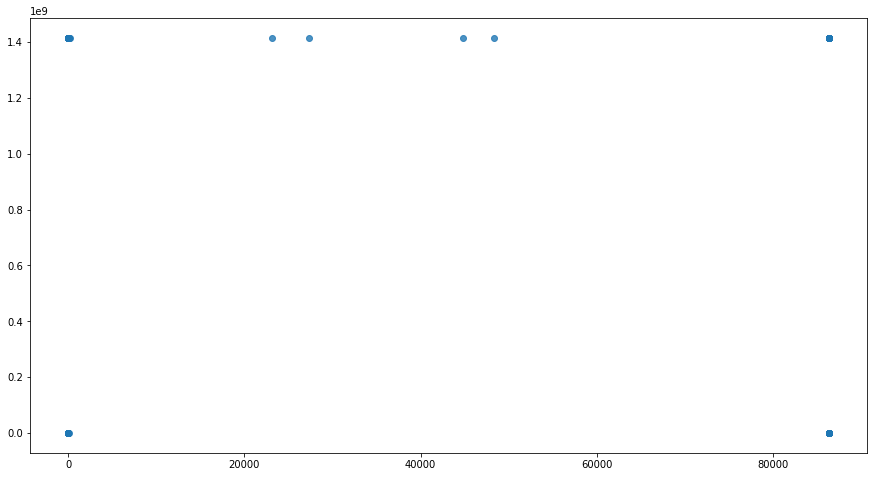

In [79]:
seaborn.regplot(dataT[14], dataT[16], fit_reg=False)

In [78]:
((dataT[14] == 0) == (dataT[16] == 0)).sum()

921

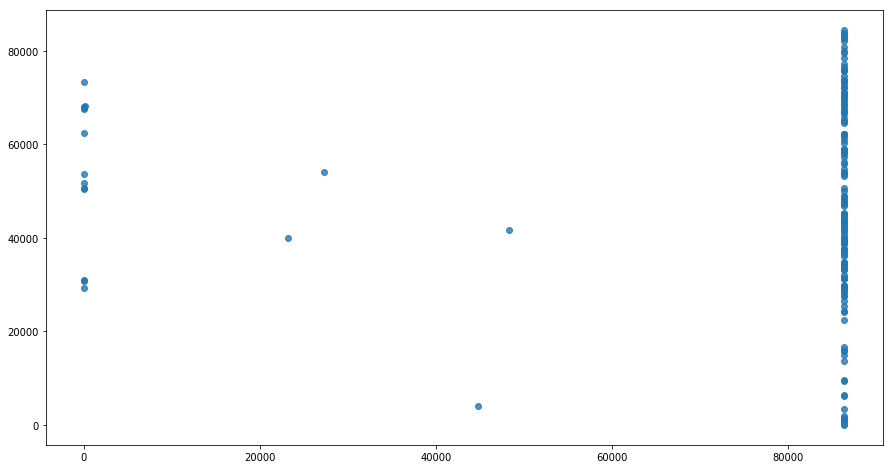

In [88]:
ind = (dataT[14] != 0) * (dataT[16] != 0)
seaborn.regplot(dataT[14, ind], dataT[16, ind] - dataT[16, ind].min(), fit_reg=False)

Что-то не очень понятное происходит со связью этих столбцов, пока оставим, как есть.

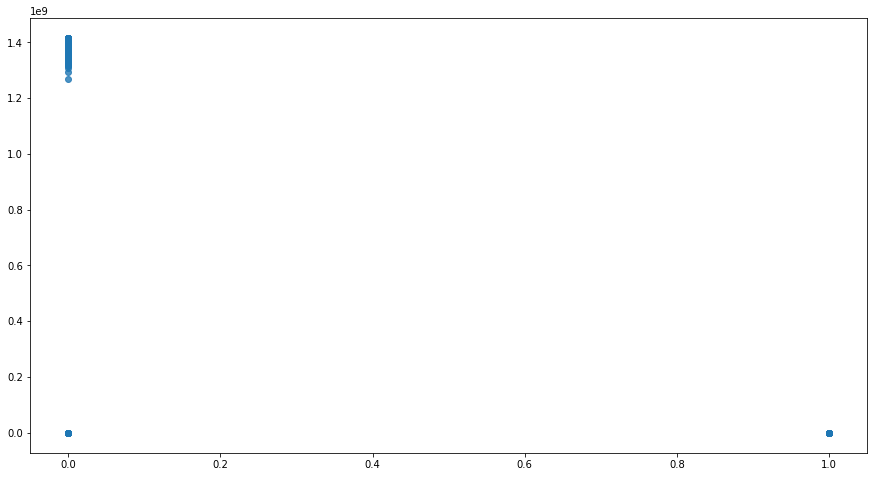

In [96]:
seaborn.regplot(dataT[12], dataT[13], fit_reg=False)

In [97]:
((dataT[12] == 0) == (dataT[13] == 0)).sum()

22

## Draw some histograms

In [101]:
columns_to_drop

[1, 15, 0]

In [129]:
def get_info(col_num, no_zeros=False):
    tmp = dataT[col_num]
    if no_zeros:
        tmp = tmp[tmp != 0]
    sd = ((tmp - tmp.min()) / (tmp.max() - tmp.min())).std()
    print('Min: {}, max: {}, mean: {}, norm_sd: {}'.format(tmp.min(), tmp.max(), tmp.mean(), sd))
    if len(np.unique(tmp)) < 20:
        print('Small amount of unique values: ', np.unique(tmp))
    seaborn.distplot(tmp)

Min: 0.0, max: 1.0, mean: 0.999, norm_sd: 0.03160696125855822
Small amount of unique values:  [ 0.  1.]


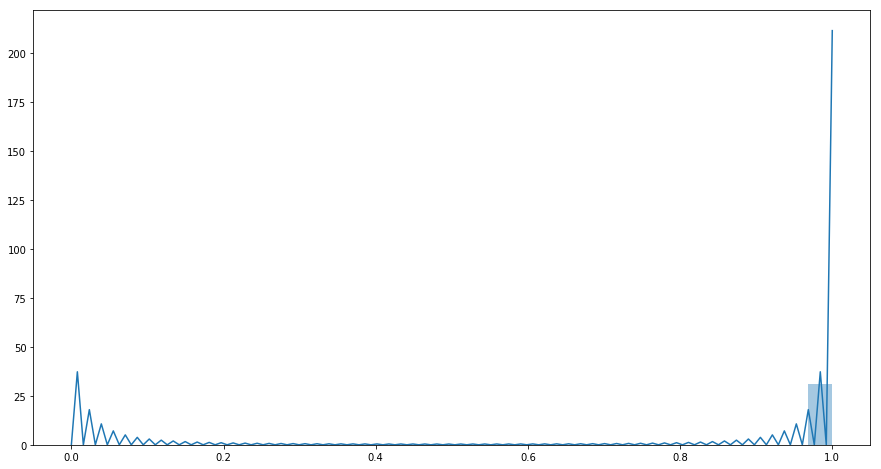

In [134]:
get_info(7)

In [140]:
(dataT[7] == 0).sum()

1

В седьмом столбце только одно значение из всех равно нулю. Вряд ли именно оно определяет мошенников, скорее похоже на баг, удалим:

In [136]:
columns_to_drop.append(7)

Min: 0.0, max: 83.0, mean: 0.174, norm_sd: 0.039446975421920265
Small amount of unique values:  [  0.   1.   3.   5.   7.  61.  83.]


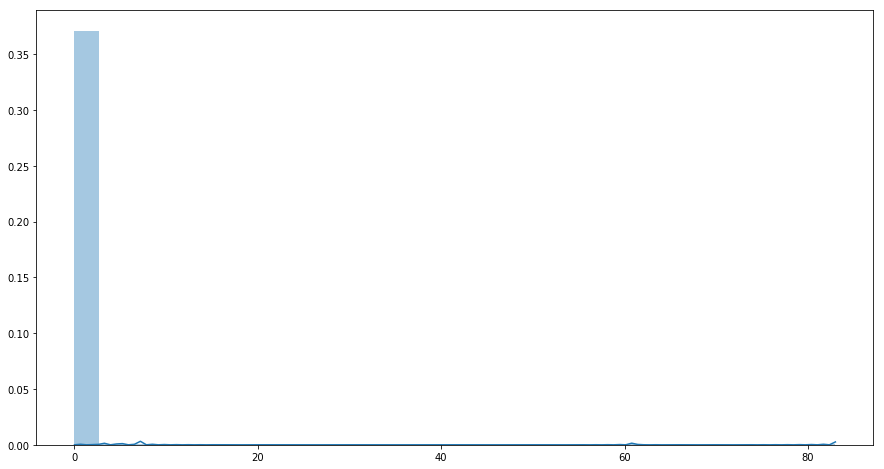

In [138]:
get_info(9)

In [141]:
(dataT[9] != 0).sum()

14

Тоже не очень информативный столбец:

In [143]:
columns_to_drop.append(9)

Min: 0.0, max: 1.0, mean: 0.011, norm_sd: 0.10430244484191156
Small amount of unique values:  [ 0.  1.]


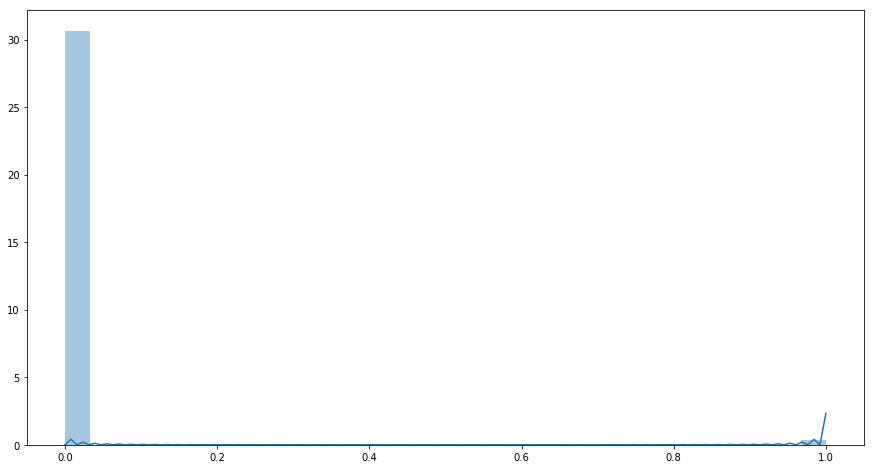

In [146]:
get_info(12)

In [148]:
(dataT[12] != 0).sum()

11

In [149]:
columns_to_drop.append(12)

Min: 1240921337.0, max: 1415737573.0, mean: 1397659715.569, norm_sd: 0.14720036629641625


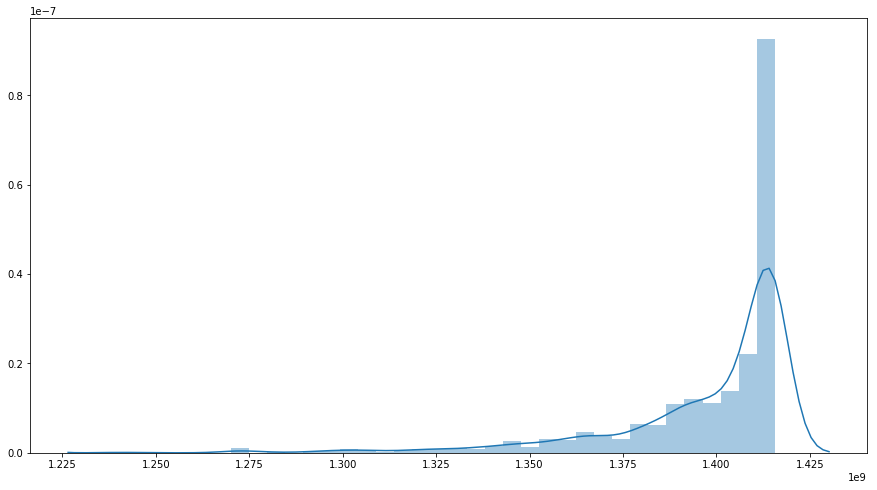

In [154]:
get_info(8, True)

Min: 1268255040.0, max: 1415739293.0, mean: 1405754048.196484, norm_sd: 0.125597665963285


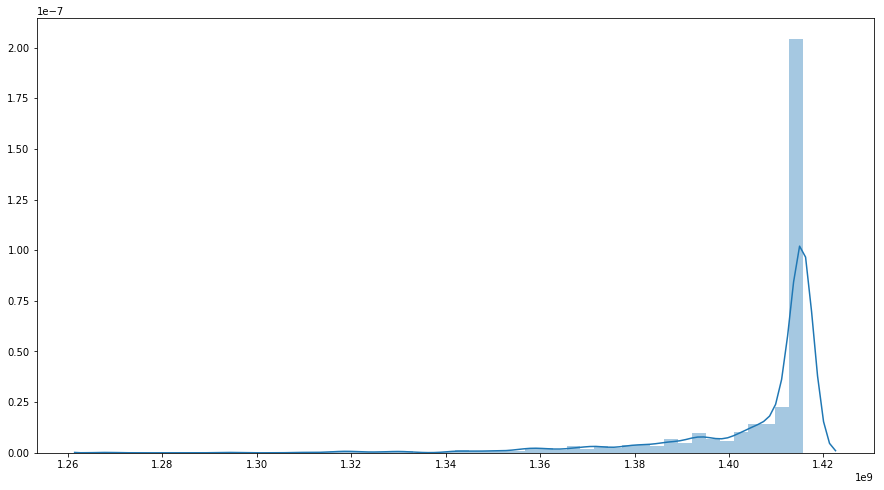

In [155]:
get_info(13, True)

8 и 13 похожи, запомним.

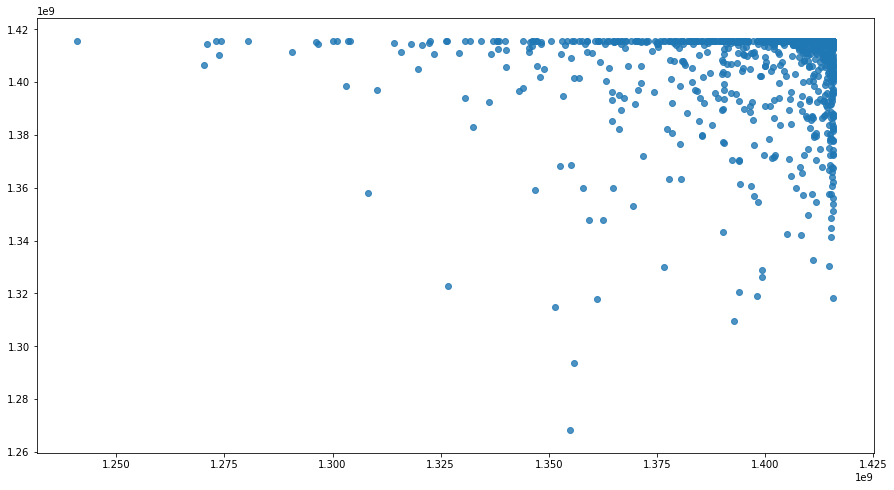

In [159]:
ind = dataT[13] != 0
seaborn.regplot(dataT[8, ind], dataT[13, ind], fit_reg=False)

## Run PCA to see if we can exclude some cols

In [169]:
columns_to_drop

[1, 15, 0, 7, 9, 12]

In [183]:
# https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml

from matplotlib.mlab import PCA

# delete cols with no variance
data2 = scipy.delete(data,columns_to_drop,1)

# run PCA
pca1 = PCA(data2)

# % of explained variance
print("Explained variance")
for d in pca1.fracs:
    print(d)

# first eigenvector
print("\n\nCoords of first eigenvector")
for i, d in enumerate(pca1.Wt[0]):
    print(i, '\t', d)

Explained variance
0.179649384866
0.12739291439
0.11266701969
0.0919737318024
0.0886726157533
0.0786936309219
0.0776944613887
0.0727478780285
0.0568606258872
0.0508450152172
0.041686568092
0.0211161539628


Coords of first eigenvector
0 	 0.249793608122
1 	 0.453105197985
2 	 -0.0646330265949
3 	 -0.0463979591983
4 	 -0.0606958134613
5 	 -0.0880682209673
6 	 0.126533829717
7 	 0.00188816011229
8 	 0.0801840164948
9 	 0.602259803386
10 	 0.570164914617
11 	 0.065420856702


First eigenvector doesn't explain much variance (18% of total variance).

If we decide that 18% of variance is ok for us, we could drop all other columns.

(Remember that column #1 in original data was dropped before PCA, and column numbers are currently shifted!)